In [1]:
import os
import glob

import DESutils
import GPRutils
import vK2KGPR
import plotGPR
import vK2KGPR
import vonkarmanFT as vk

import numpy as np
import astropy.units as u
import astropy.table as tb
from astropy.time import Time
import matplotlib.pyplot as plt
plt.style.use('~/GitHub/custom-matplotlib/custom.mplstyle')

from IPython import embed
from importlib import reload
import warnings
warnings.filterwarnings("ignore")

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
def timexi(
    exps,
    rMax,
    errorBars=False,
    plotPercs=False,
    plotRed=False,
    plotxif=False, plotxi0=False,
    plotRMSf=False, plotRMS0=False,
    ylim=(0, None), save=None
        ):

    plt.figure(figsize=(20, 10))
    
    ylist = []
    for exp in exps:
        dC = GPRutils.loadFITS(exp)
        obs = GPRutils.dataContainer().load(dC.expNum, returnObs=True)
        
        xi1, xi2 = dC.JackKnifeXi(rMax=rMax)
        
        xi0 = np.abs(xi1[0].value)
        Xerr = xi1[1].value
        Yerr = xi1[2].value
        xi0err = np.sqrt(Xerr**2 + Yerr**2)

        xif = np.abs(xi2[0].value)
        Xerr = xi2[1].value
        Yerr = xi2[2].value
        xiferr = np.sqrt(Xerr**2 + Yerr**2)

        red = xi0/xif
        rederr = np.sqrt(((xi0err/xi0)**2 + (xiferr/xif)**2) * red**2)
    
        if dC.band == "g": c = "tab:green"
        if dC.band == "r": c = "tab:red"
        if dC.band == "i": c = "fuchsia"
        if dC.band == "z": c = "gold"
        if dC.band == "Y": c = "black"
            
        if plotRed:
            y = red
            yerr = rederr
            ylabel = r"Reduction in $\xi_{0}$"
            unit = "x Reduction"
        elif plotxif:
            y = xif
            yerr = xiferr
            ylabel = r"$\xi_{0}$ GPR Model Subtracted [mas$^2$]"
            unit = r" mas$^2$"
        elif plotxi0:
            y = xi0
            yerr = xi0err
            ylabel = r"$\xi_{0}$ Raw [mas$^2$]"
            unit = r" mas$^2$"
        elif plotRMSf:
            y = np.sqrt(xif/2)
            yerr = np.abs(y / (2 * xif)) * xiferr
            ylabel = r"$\sqrt{\xi_{0}/2}$ GPR Model Subtracted [mas]"
            unit = " mas"
        elif plotRMS0:
            y = np.sqrt(xi0/2)
            yerr = np.abs(y / (2 * xi0)) * xi0err
            ylabel = r"$\sqrt{\xi_{0}/2}$ Raw [mas]"
            unit = " mas"
        ylist.append(y)

        if errorBars:
            plt.errorbar(
                obs.datetime, y,
                yerr=yerr,
                c=c, marker=".", markersize=10,
                linewidth=0.5, capsize=1)
        else:
            plt.scatter(obs.datetime, y, c=c, marker=".")
    
    plt.xlim((None, None))
    plt.ylim(ylim)
    
    if plotPercs:
        mean = np.mean(ylist)
        mean = plt.axhline(y=mean, c="tab:red", linewidth=2, ls="-", label=f"{mean:.2f}{unit} (Mean)")
        percs = np.percentile(ylist, (25, 50, 75))
        perc25 = plt.axhline(y=percs[0], c="black", linewidth=2, ls=":", label=f"{percs[0]:.2f}{unit} (1st Quartile)")
        perc50 = plt.axhline(y=percs[1], c="black", linewidth=2, ls="--", label=f"{percs[1]:.2f}{unit} (2nd Quartile)")
        perc75 = plt.axhline(y=percs[2], c="black", linewidth=2, ls=":", label=f"{percs[2]:.2f}{unit} (3rd Quartile)")
        legend2 = plt.legend(handles=[mean, perc25, perc50, perc75], loc="upper left", framealpha=0.50)
        plt.gca().add_artist(legend2)
        
    # Central wavelength of DES passband filters:
    # g: 473 nm
    # r: 642 nm
    # i: 784 nm
    # z: 926 nm
    # From Flaugher et al. (2015) "The Dark Energy Camera" arxiv:1504.02900
    gband = plt.scatter(Time(0, format="mjd").datetime, 0, alpha=1, color="tab:green", label="g band")
    rband = plt.scatter(Time(0, format="mjd").datetime, 0, alpha=1, color="tab:red", label="r band")
    iband = plt.scatter(Time(0, format="mjd").datetime, 0, alpha=1, color="fuchsia", label="i band")
    zband = plt.scatter(Time(0, format="mjd").datetime, 0, alpha=1, color="gold", label="z band")
    Yband = plt.scatter(Time(0, format="mjd").datetime, 0, alpha=1, color="black", label="Y band")
    legend1 = plt.legend(handles=[gband, rband, iband, zband, Yband], loc="upper right", framealpha=0.50)
    plt.gca().add_artist(legend1)
    
    plt.xlabel("Date of Exposures")
    plt.ylabel(ylabel)

    plt.grid()
    plt.grid(which="minor", axis="y")
    
    if save is not None:
        plt.savefig(save)
    plt.show()

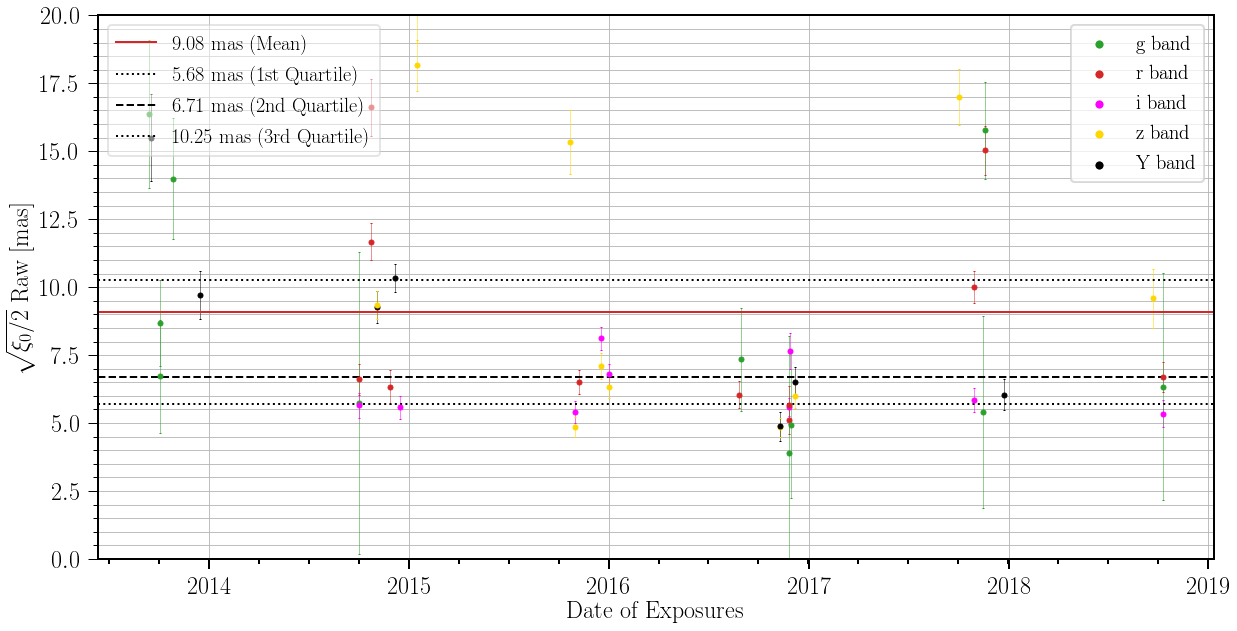

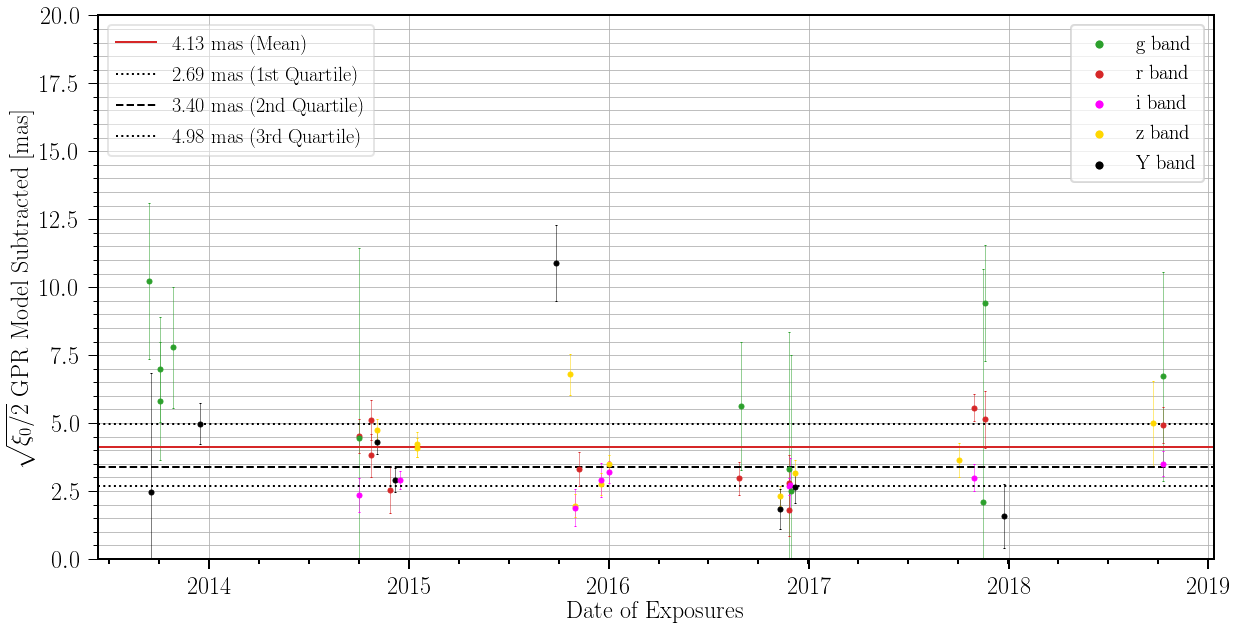

In [5]:
FITSfiles = sorted(glob.glob(f"/home/fortino/GPRSolutions/eris/GPR.??????.?RC.fits"))
rMax = 0.5*u.arcmin
ylim = (0, 20)
# ylim = (0, None)
savepath = os.path.dirname(FITSfiles[0])

timexi(FITSfiles, rMax, errorBars=True, plotPercs=True, plotRMS0=True, ylim=ylim,
#     save=os.path.join(savepath, "timexi_raw.png")
)

timexi(FITSfiles, rMax, errorBars=True, plotPercs=True, plotRMSf=True, ylim=ylim,
#     save=os.path.join(savepath, "timexi_GPR.png")
)

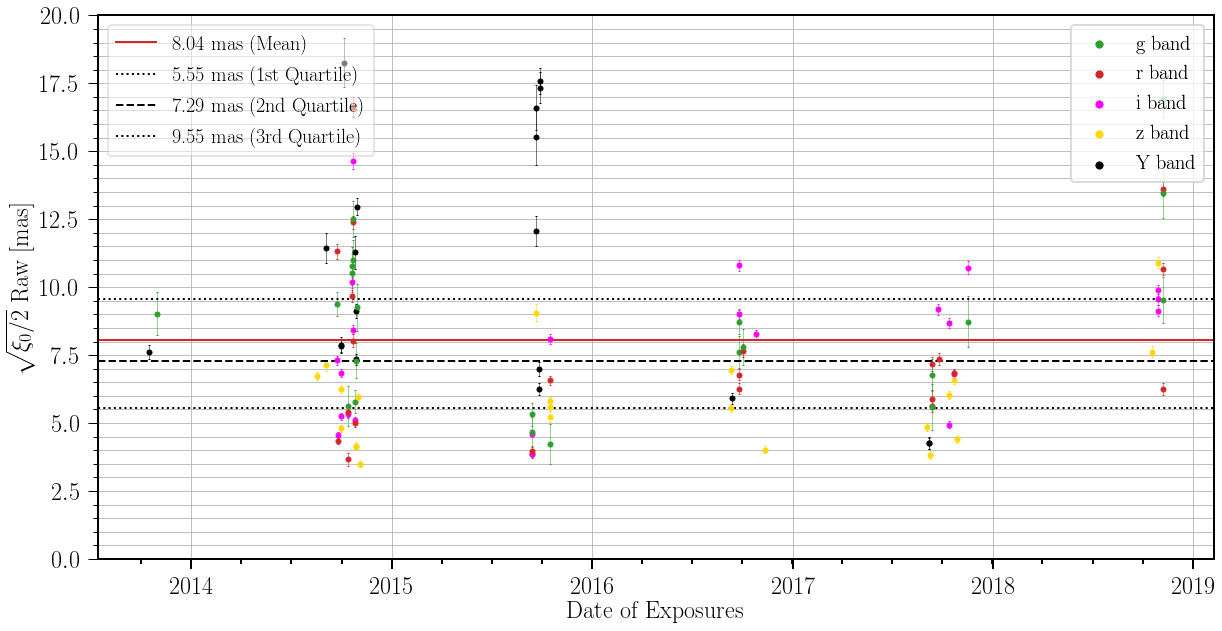

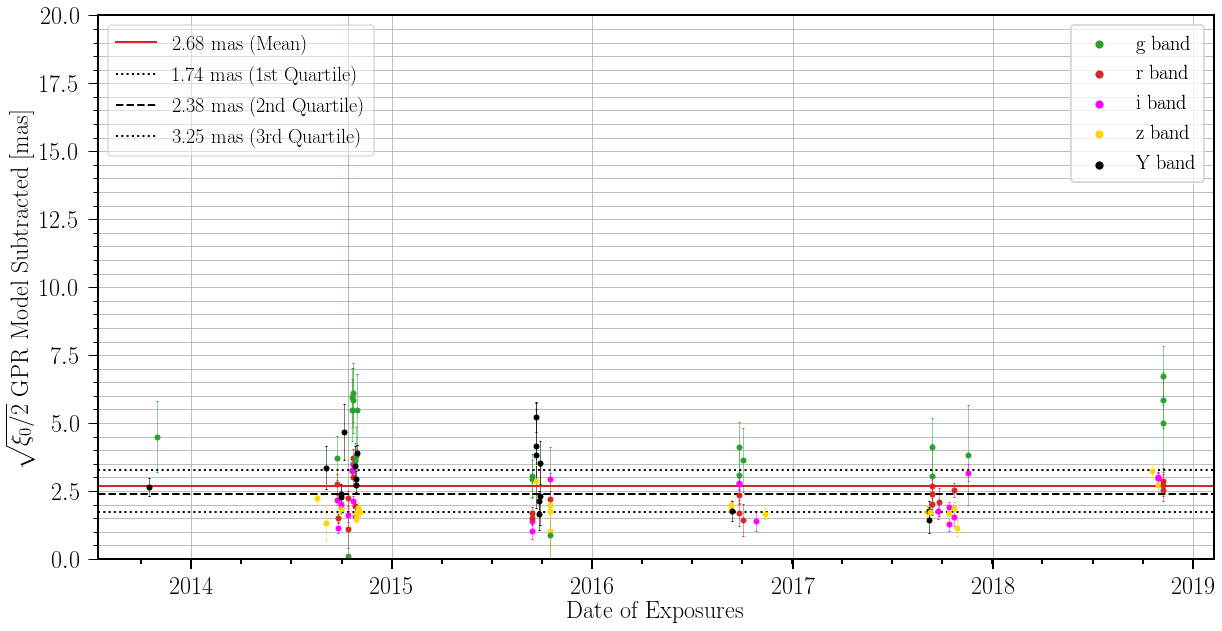

In [3]:
FITSfiles = sorted(glob.glob(f"/home/fortino/GPRSolutions/zone134/GPR.??????.?RC.fits"))
rMax = 0.5*u.arcmin
ylim = (0, 20)
# ylim = (0, None)
savepath = os.path.dirname(FITSfiles[0])

timexi(FITSfiles, rMax, errorBars=True, plotPercs=True, plotRMS0=True, ylim=ylim,
#     save=os.path.join(savepath, "timexi_raw.png")
)

timexi(FITSfiles, rMax, errorBars=True, plotPercs=True, plotRMSf=True, ylim=ylim,
#     save=os.path.join(savepath, "timexi_GPR.png")
)

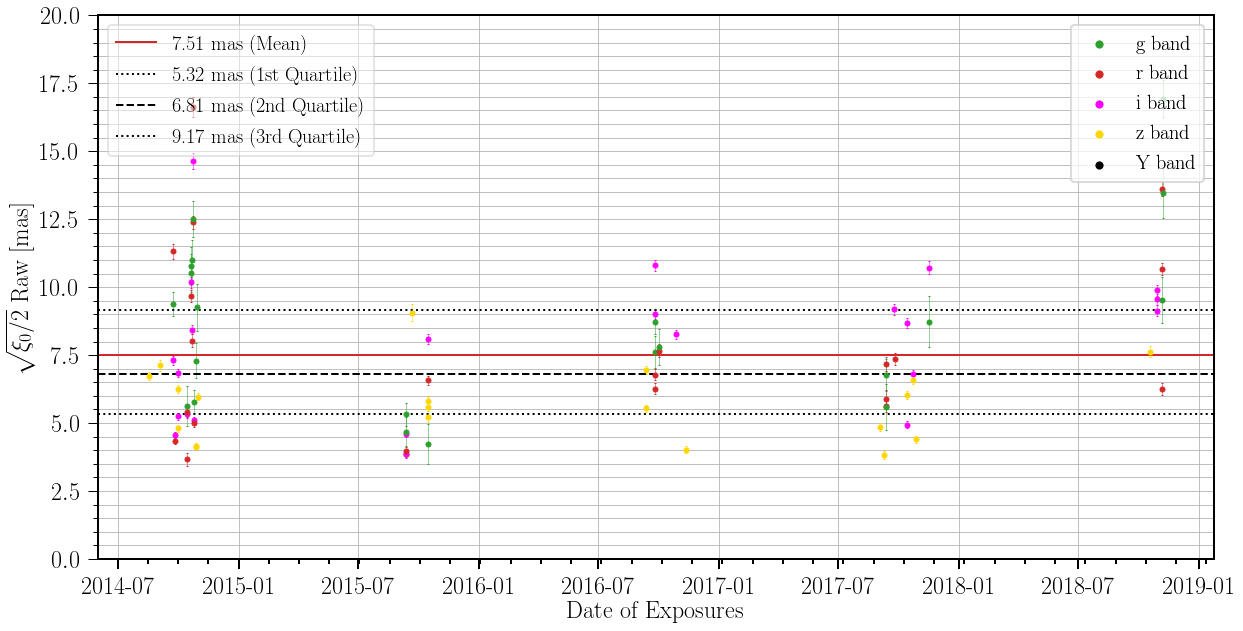

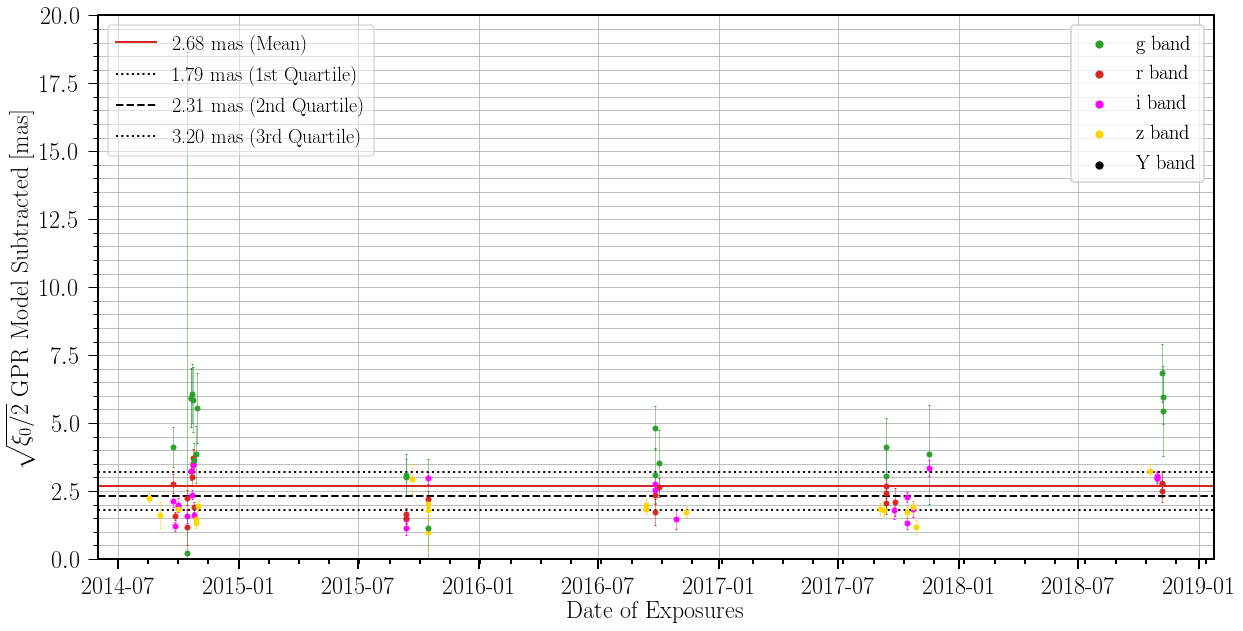

In [4]:
FITSfiles = sorted(glob.glob(f"/home/fortino/GPRSolutions/dualOpt_NMmax/GPR.??????.?RC.fits"))
rMax = 0.5*u.arcmin
ylim = (0, 20)
# ylim = (0, None)
savepath = os.path.dirname(FITSfiles[0])

timexi(FITSfiles, rMax, errorBars=True, plotPercs=True, plotRMS0=True, ylim=ylim,
#     save=os.path.join(savepath, "timexi_raw.png")
)

timexi(FITSfiles, rMax, errorBars=True, plotPercs=True, plotRMSf=True, ylim=ylim,
#     save=os.path.join(savepath, "timexi_GPR.png")
)